# Day 14: Monte Carlo, Continued

---

Monte Carlo concepts
- Uncertainty propagation
- Estimating distributions
- Varying deterministic variables with `df_det`
- Random seeds / common random numbers
  - Important for optimization; helps ensure smoothness
- Estimating probabilities


In [1]:
import pandas as pd 
import grama as gr 
import numpy as np

from plotnine import *

DF = gr.Intention()


## Monte Carlo on Grama Models

---

### Uncertainty Propagation

Remember from last time we looked at the example $F = Z^2$ where $Z \sim N(0, 1^2)$.


eval_monte_carlo() is rounding n...


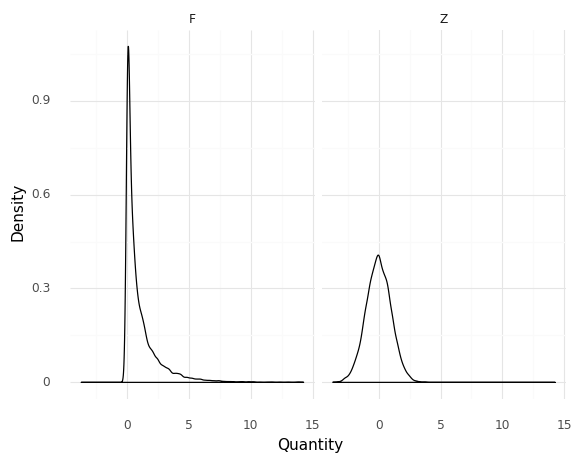

<ggplot: (8743344841674)>

In [2]:
md_example = (
    ## Build a simple model
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(F=df.Z**2),
        var=["Z"],
        out=["F"],
    )
    >> gr.cp_marginals(Z=dict(dist="norm", loc=0, scale=1))
    >> gr.cp_copula_independence()
)

(
    md_example
    ## Approximate distribution using Monte Carlo
    >> gr.ev_monte_carlo(n=1e4, df_det="nom")
    
    ## Do some data reshaping
    >> gr.tf_gather("var", "value", ["F", "Z"])
    
    ## Visualize
    >> ggplot(aes("value"))
    + geom_density()
#     + geom_vline(xintercept=1, linetype="dashed")
    
    + facet_wrap("var")
    + theme_minimal()
    + labs(x="Quantity", y="Density")
)

Remind me: What observations did we have about these two random quantities $Z, F = Z^2$?

- ???

<br><br><br>

*Aside*: I did an exact comparison of $Z$ against $Z^2 \sim \chi^2_1$, and it turns out the point where $Z = Z^2 = 1$ has the same density. This somewhat endorses the "stretch-squeeze around 1" idea we discussed before.

![norm chisq comparison](./images/norm-chisq.png)


<br><br><br>

> A function $f$ with random inputs $X$ will produce a random output $F$.

Note that if the inputs $X \in \mathbb{R}^d$ are *random* $X \sim \rho$, then any function of those random inputs is itself random $F = f(X) \sim \psi$. As we saw above, the distribution for $F \sim \psi$ can be weird and complicated.

> Random inputs are said to *induce* randomness on outputs.

Calling`gr.ev_monte_carlo()` on a Grama model draws random values for the `inputs` and computes values for each `output`.

In [3]:
(
    md_example
    >> gr.ev_monte_carlo(n=4, df_det="nom")
)

,Z,F
0,1.487007,2.211191
1,1.120636,1.255825
2,0.442912,0.196171
3,-1.393315,1.941328


> `gr.ev_monte_carlo()` draws random inputs, and evaluates the model functions to produce random outputs.

We can do all kinds of useful work with these samples; let's look at that work in-context:


### Cantilever Beam model

As a running example, let's look at the cantilever beam model. The cantilever beam has a width $w$ and thickness $t$, elasticity $E$, yield strength $Y$, and is subjected to loads $H, V$.

![schematic](./images/cantilever_beam_schematic.png)

Figure credit: [Richard W. Fenrich](https://arc.aiaa.org/doi/abs/10.2514/1.J058345).

There's a fair bit going on in this model, so the primary features I want you to concentrate on are the *limit state functions* `g_disp` and `g_stress`. 

> For limit state functions $g$
> $$g > 0\text{ corresponds to success}$$
> $$g \leq 0\text{ corresponds to failure}$$

The beam limit states are

$$g_{\text{disp}} = \delta_{\max} - \delta_{tip}$$
$$g_{\text{stress}} = \sigma_{\max} - \sigma_{\text{applied}}$$

In [4]:
from grama.models import make_cantilever_beam
md_beam = make_cantilever_beam()

md_beam.printpretty()


model: Cantilever Beam

  inputs:
    var_det:
      t: [2, 4]
      w: [2, 4]

    var_rand:
      H: (+1) norm, {'loc': 500.0, 'scale': 100.0}
      V: (+1) norm, {'loc': 1000.0, 'scale': 100.0}
      E: (+0) norm, {'loc': 29000000.0, 'scale': 1450000.0}
      Y: (-1) norm, {'loc': 40000.0, 'scale': 2000.0}

    copula:
      Independence copula

  functions:
      cross-sectional area: ['w', 't'] -> ['c_area']
      limit state: stress: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_stress']
      limit state: displacement: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_disp']



### Estimating distributions

We talked about Monte Carlo as a way to approximate the mean of a random variable:


In [5]:
(
    md_beam
    >> gr.ev_monte_carlo(n=1e3, df_det="nom")
    >> gr.tf_summarize(
        g_disp_mean=gr.mean(DF.g_disp),
        g_stress_mean=gr.mean(DF.g_stress),
    )
)

eval_monte_carlo() is rounding n...


,g_disp_mean,g_stress_mean
0,0.345331,0.167872


These mean values are greater than zero, which is a positive indication. We want $g > 0$, so *on average* the structure seems safe. But remember that the mean is only a typical value; what if we want a beam that isn't just "typically" safe?

> For a critical failure mode, we don't just want it to *typically* work! Therefore the mean of a limit state $g$ isn't the right quantity to study.

When we want more than just the mean; calling `gr.plot_auto()` on the output of `gr.eval_monte_carlo()` will automatically plot a histogram for each output:


eval_monte_carlo() is rounding n...
Calling plot_hists....


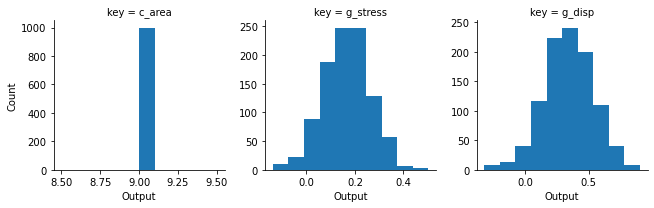

In [6]:
(
    md_beam
    >> gr.ev_monte_carlo(n=1e3, df_det="nom")
    >> gr.pt_auto()
)

Remember that:

$$g > 0\text{ corresponds to success}$$
$$g \leq 0\text{ corresponds to failure}$$

Based on these histograms, how safe does the cantilever beam seem to be?

<br><br><br>

Now we can see that a small fraction of the distributions for `g_disp` and `g_stress` lie below zero; this indicates a small---but nonzero---probability of failure.

These histograms are an *approximation* of the real density for the outputs.


### Sweeping deterministic values

Let's take another look at the `printpretty()` output of `md_beam`; note that it has both deterministic and random variables:

In [7]:
md_beam.printpretty()

model: Cantilever Beam

  inputs:
    var_det:
      t: [2, 4]
      w: [2, 4]

    var_rand:
      H: (+1) norm, {'loc': 500.0, 'scale': 100.0}
      V: (+1) norm, {'loc': 1000.0, 'scale': 100.0}
      E: (+0) norm, {'loc': 29000000.0, 'scale': 1450000.0}
      Y: (-1) norm, {'loc': 40000.0, 'scale': 2000.0}

    copula:
      Independence copula

  functions:
      cross-sectional area: ['w', 't'] -> ['c_area']
      limit state: stress: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_stress']
      limit state: displacement: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_disp']



Note that the beam model has both *deterministic* and *random* variables:

| Input | Type | Meaning |
|---|---|---|
| `w` | Deterministic | Design variable: Width |
| `t` | Deterministic | Design variable: Thickness |
| `H` | Random | Uncertainty: Horizontal tip load |
| `V` | Random | Uncertainty: Vertical tip load |
| `E` | Random | Uncertainty: Material elasticity |
| `Y` | Random | Uncertainty: Material (yield) strength |

What happens to the deterministic variables `w, t` when we set `df_det="nom"`?


In [8]:
(
    md_beam
    >> gr.ev_monte_carlo(n=4, df_det="nom")
)

,H,E,Y,V,t,w,c_area,g_stress,g_disp
0,309.561266,2.455624e+07,37886.826829,891.481654,3.0,3.0,9.0,0.279925,0.355717
1,646.953205,2.961299e+07,38533.677240,1055.503157,3.0,3.0,9.0,0.017533,0.189013
2,676.873419,2.948730e+07,39257.871198,843.840621,3.0,3.0,9.0,0.136606,0.441849
3,493.821286,2.992815e+07,44782.113596,1046.602718,3.0,3.0,9.0,0.263762,0.343982


What values do `w, t` take?

<br><br><br>

Note that `w, t` take single, fixed values. Setting `df_det="nom"` sets *nominal* values for all the deterministic inputs. Note that if you want to set specific values for the deterministic variables, you can set `df_det` to a DataFrame of desired values.

> The `df_det` argument allows you to sweep deterministic variables with Monte Carlo

The helper `gr.df_make()` is a convenient way to make a DataFrame; in particular, you can hold one or more values constant and sweep one value. For instance, the line

`gr.df_make(w=3.0, t=np.linspace(2, 4))`

will set `w == 3.0` and sweep over values of `t`.


In [9]:
(
    ## Generate a Monte Carlo sample, sweep with values of t
    md_beam
    >> gr.ev_monte_carlo(
        n=3,
        df_det=gr.df_make(w=3.0, t=np.linspace(2, 4, num=4)),
    )
    
    ## Summarize
    >> gr.tf_summarize(
        g_stress_mean=gr.mean(DF.g_stress),
        g_stress_sd=gr.sd(DF.g_stress),
    )
)


,g_stress_mean,g_stress_sd
0,0.040932,0.483082


We swept over values of $t$, so why doesn't $t$ show up in these results?

<br><br><br>

In order to avoid summarizing over the different samples for different values of $t$, we need to `gr.tf_group_by(DF.t)` to compute each mean/sd within a *group* defined by unique values of $t$.


In [10]:
(
    ## Generate a Monte Carlo sample at values of t
    md_beam
    >> gr.ev_monte_carlo(
        n=1e2,
        df_det=gr.df_make(w=3.0, t=np.linspace(2, 4, num=6)),
    )
    
    ## Define a grouping of the DataFrame
    >> gr.tf_group_by(DF.t)
    ## Summarize at each value of t
    >> gr.tf_summarize(
        g_stress_mean=gr.mean(DF.g_stress),
        g_stress_sd=gr.sd(DF.g_stress),
    )
)

eval_monte_carlo() is rounding n...


,t,g_stress_mean,g_stress_sd
0,2.0,-0.671156,0.142241
1,2.4,-0.219830,0.109807
2,2.8,0.060222,0.090909
3,3.2,0.247114,0.079138
4,3.6,0.378759,0.071427
5,4.0,0.475434,0.066166


> When sweeping with `df_det`, we need to use a `gr.tf_group_by()` before summarizing.

Using a `gr.tf_group_by()` before the summary provides a mean and standard deviation at each value of `t`, which we can plot:


eval_monte_carlo() is rounding n...


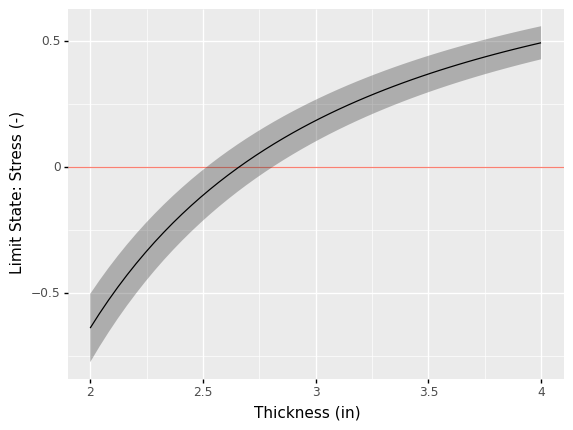

<ggplot: (8743338418183)>

In [11]:
(
    ## Generate a Monte Carlo sample at values of t
    md_beam
    >> gr.ev_monte_carlo(
        n=1e2,
        df_det=gr.df_make(w=3.0, t=np.linspace(2, 4)),
    )
    
    ## Summarize at each value of t
    >> gr.tf_group_by(DF.t)
    >> gr.tf_summarize(
        g_stress_mean=gr.mean(DF.g_stress),
        g_stress_sd=gr.sd(DF.g_stress),
    )
    
    ## Visualize
    >> ggplot(aes("t"))
    + geom_hline(yintercept=0, color="salmon")
    + geom_ribbon(
        aes(
            ymin="g_stress_mean - g_stress_sd", 
            ymax="g_stress_mean + g_stress_sd",
        ), 
        alpha=1/3,
    )
    + geom_line(aes(y="g_stress_mean"))
    + labs(
        x="Thickness (in)",
        y="Limit State: Stress (-)",
    )
)

This is great, because we can think of the standard deviation as a means to add a *principled* margin-of-safety to our design. We could---for instance---choose a thickness $t$ where the shaded band is above zero. We'll see a more principled way to use this information for design when we talk about *reliability* later.


### Random seeds

One of the key arguments to `gr.eval_monte_carlo()` is `seed`; this sets the [random seed](https://en.wikipedia.org/wiki/Random_seed) for [pseudorandom](https://en.wikipedia.org/wiki/Pseudorandomness) number generation. Setting a fixed seed will "fix" the values generated by `gr.eval_monte_carlo()`. This raises all kinds of questions about "what is random?" that we won't get into in this class....

*Aside*: Before the advent of modern computing and access to high-quality pseudorandom number generators, scientists would use dice, wheels, and [published tables of randomly-generated digits](https://en.wikipedia.org/wiki/A_Million_Random_Digits_with_100,000_Normal_Deviates).  This has led to some humorous [Amazon reviews](https://www.amazon.com/product-reviews/0833030477/). There is, *astoundingly*, an [audiobook](http://amillionrandomdigits.com/index.html) version of this work as well.


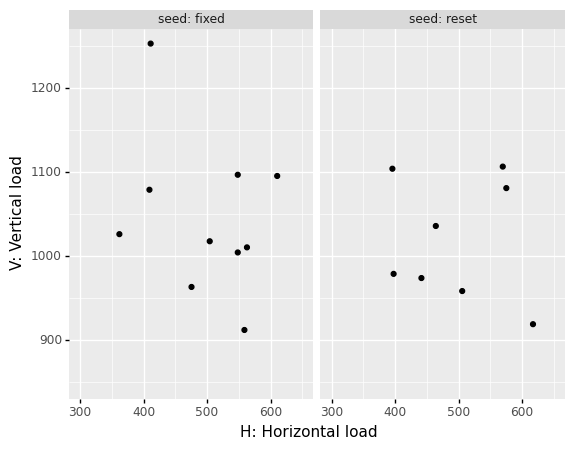

<ggplot: (8743338332817)>

In [12]:
# Reset the seed for this demo
np.random.seed()

# Note the difference between these two lines....
df_sample_rand  = gr.eval_monte_carlo(md_beam, n=10, df_det="nom")
df_sample_fixed = gr.eval_monte_carlo(md_beam, n=10, df_det="nom", seed=101)

# Visualize both samples
(
    df_sample_rand
    >> gr.tf_mutate(source="seed: reset")
    >> gr.tf_bind_rows(
        df_sample_fixed
        >> gr.tf_mutate(source="seed: fixed")
    )
    
    >> ggplot(aes("H", "V"))
    + geom_point()
    
    + coord_cartesian(
        xlim=(300, 650),
        ylim=(850, 1250),
    )
    + facet_wrap("source")
    + labs(x="H: Horizontal load", y="V: Vertical load")
)


Note that with a fixed seed the random numbers don't change. Setting the seed gives us a fixed sample. Here's a rough rule-of-thumb on setting seeds:

> - When testing the statistical properties of a random algorithm, it's important to test a variety of seeds.
> - When using a random algorithm to do design, it's best to fix a single seed.

Fixing a random seed allows us to generate *common random numbers*.


### Common random numbers

Remember how we did a sweep over `t` with the beam model? The response looks smooth. That's because `gr.eval_monte_carlo()` uses a single sample (set of realizations) for each setting of the deterministic variables. If we plot each realization $t$, we'll see points that appear to form curves:


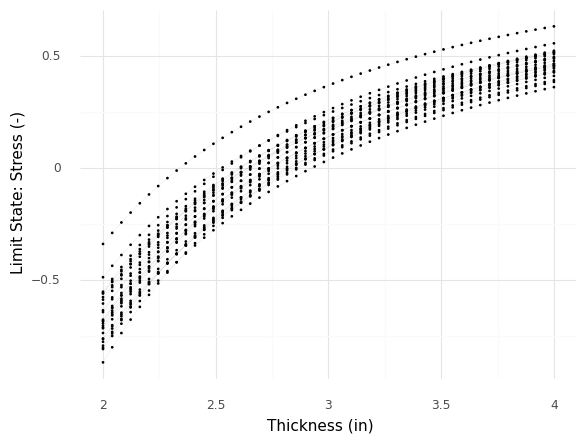

<ggplot: (8743338334760)>

In [13]:
(
    ## Generate a Monte Carlo sample at values of t
    md_beam
    >> gr.ev_monte_carlo(
        n=25,
        df_det=gr.df_make(w=3.0, t=np.linspace(2, 4)),
    )
    
    ## Visualize each realization; we get smooth sweeps across `t`
    >> ggplot(aes("t", "g_stress"))
    + geom_line(aes(group="E"), color="grey", size=0.1, alpha=1/3)
    + geom_point(size=0.1)
    
    + theme_minimal()
    + labs(
        x="Thickness (in)",
        y="Limit State: Stress (-)"
    )
)

If we *instead* draw an independent sample for each value of $t$, we will no longer see a "smooth" response:


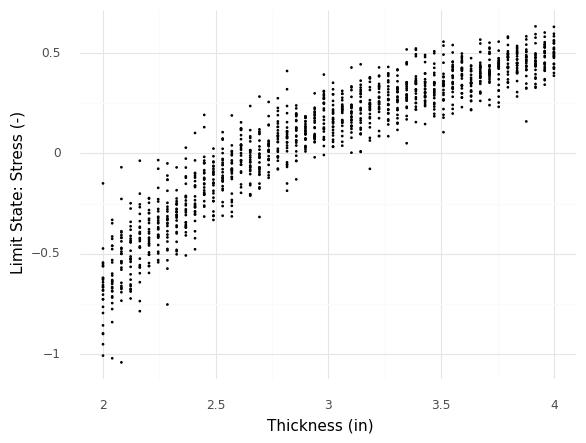

<ggplot: (8743338332895)>

In [14]:
## Purposefully draw an independent sample for each t value
df_sweep_t = gr.df_make(w=3.0, t=np.linspace(2, 4))
df_sweep = pd.DataFrame()

for i in range(df_sweep_t.shape[0]):
    df_tmp = (
        md_beam
        >> gr.ev_monte_carlo(
            n=25,
            df_det=df_sweep_t.iloc[[i]],
            # seed=101, # Set seed for common random numbers
        )
    )
    
    df_sweep = pd.concat((df_tmp, df_sweep), axis=0)
    
(
    df_sweep
    >> ggplot(aes("t", "g_stress"))
    + geom_point(aes(group="E"), size=0.1)
    
    + theme_minimal()
    + labs(
        x="Thickness (in)",
        y="Limit State: Stress (-)"
    )
)

Where this really matters is in using these results to do *optimization*; imagine we aim to find the point in `t` where the mean of `g_stress` crosses zero. The following curve shows us that using independent samples will give us a jagged curve, which will in turn make optimization using this result challenging:


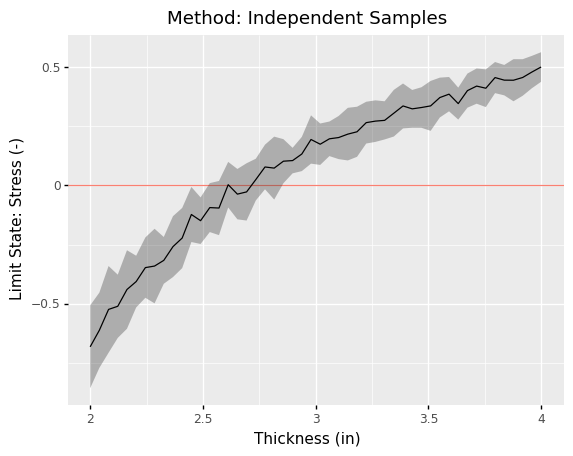

<ggplot: (8743337135647)>

In [15]:
(
    df_sweep
    ## Summarize at each value of t
    >> gr.tf_group_by(DF.t)
    >> gr.tf_summarize(
        g_stress_mean=gr.mean(DF.g_stress),
        g_stress_sd=gr.sd(DF.g_stress),
    )
    
    >> ggplot(aes("t"))
    + geom_hline(yintercept=0, color="salmon")
    + geom_ribbon(aes(ymin="g_stress_mean - g_stress_sd", ymax="g_stress_mean + g_stress_sd"), alpha=1/3)
    + geom_line(aes(y="g_stress_mean"))
    + labs(
        x="Thickness (in)",
        y="Limit State: Stress (-)",
        title="Method: Independent Samples"
    )
)


The *one simple change* you can make to deal with this is give an integer value for `seed` when calling `gr.eval_monte_carlo()`. This will give you *common random numbers* across different values of the deterministic variables.


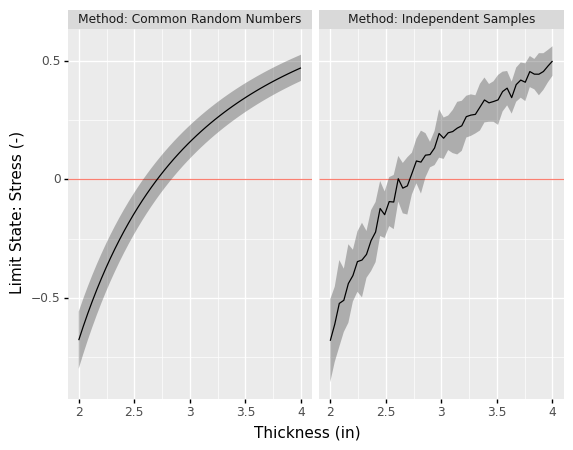

<ggplot: (8743338224378)>

In [16]:
## Purposefully draw an independent sample for each t value
df_sweep_t = gr.df_make(w=3.0, t=np.linspace(2, 4))
df_sweep_com = pd.DataFrame()

for i in range(df_sweep_t.shape[0]):
    df_tmp = (
        md_beam
        >> gr.ev_monte_carlo(
            n=25,
            df_det=df_sweep_t.iloc[[i]],
            seed=101, # Set seed for common random numbers
        )
    )
    
    df_sweep_com = pd.concat((df_tmp, df_sweep_com), axis=0)
    
## Visualize
(
    # Summarize the data
    df_sweep_com
    >> gr.tf_group_by(DF.t)
    >> gr.tf_summarize(
        g_stress_mean=gr.mean(DF.g_stress),
        g_stress_sd=gr.sd(DF.g_stress),
    )
    >> gr.tf_mutate(method="Method: Common Random Numbers")
    
    # Bind previous results for comparison
    >> gr.tf_bind_rows(
        df_sweep
        >> gr.tf_group_by(DF.t)
        >> gr.tf_summarize(
            g_stress_mean=gr.mean(DF.g_stress),
            g_stress_sd=gr.sd(DF.g_stress),
        )
        >> gr.tf_mutate(method="Method: Independent Samples")
    )
    
    # Make the visual
    >> ggplot(aes("t"))
    + geom_hline(yintercept=0, color="salmon")
    + geom_ribbon(aes(ymin="g_stress_mean - g_stress_sd", ymax="g_stress_mean + g_stress_sd"), alpha=1/3)
    + geom_line(aes(y="g_stress_mean"))
    
    + facet_wrap("method")
    + labs(
        x="Thickness (in)",
        y="Limit State: Stress (-)",
    )
)

> Common random numbers are important when doing sweeps or optimization.
> You can set a fixed seed in Monte Carlo to use common random numbers.


## Estimating Probabilities

---

Remember that probability is the area under the PDF; this is an integral over a desired set $A$.

$$\mathbb{P}[X \in A] = \int_A \rho(x)dx$$

We're going to re-express probability in terms of a mean (expectation); this will allow us to use Monte Carlo to estimate probabilities. First, let's define the *indicator function* $1(x \in A)$, which is the function

$$1(x \in A) = \left\{\begin{array}{ll} 1 & x \in A \\ 0 & x \not\in A\end{array}\right.$$

This allows us to re-express an integral over a set $A$ to an integral over the entire domain

$$\int_A \rho(x)dx = \int_{\mathbb{R}^d} 1(x \in A)\rho(x) dx.$$

But remember that an integral of a random variable against its density is nothing more than the mean:

$$\int_{\mathbb{R}^d} 1(x \in A)\rho(x) dx = \mathbb{E}[1(X \in A)]$$

Chaining all these expressions together, we can state

$$\mathbb{P}[X \in A] = \mathbb{E}[1(X \in A)].$$

We can estimate a probability using Monte Carlo by using this framing as a mean:

$$\mathbb{E}[1(X \in A)] \approx \frac{1}{n}\sum_{i=1}^n 1(X_i \in A)$$

> The probability of an event $X \in A$ can be approximated using Monte Carlo. To do this, you must use an indicator function $I = 1(X \in A)$ and approximate the mean of $I$.


### Using the Indicator Function

For us to make use of the Monte Carlo estimator $\mathbb{E}[1(X \in A)] \approx \frac{1}{n}\sum_{i=1}^n 1(X_i \in A)$, we need to define a set $A$, and construct an indicator to reflect that set. For example, with the cantilever beam problem, we have

$$g > 0\text{ corresponds to success}$$
$$g \leq 0\text{ corresponds to failure}$$

So if we wanted to compute the probability of failure, we would define $A = \{x\,|\,g(x) \leq 0\}$.

In Python, we can directly use inequalities to implement an indicator function; for instance, the code

`df.g_stress <= 0`

will return a Series (column) which will take the value `True` when `g_stress <=0`, and the value `False` when `g_stress > 0`.


### Boolean Arithmetic

You might be wondering how we can *possibly* do math with `True` and `False` values. Something important to know is that Python treats `True == 1` and `False == 0`. This means we can do math with boolean values:


In [17]:
True == 1


True

In [18]:
False == 0

True

In [19]:
0 + True

1

Importantly, this means we can compute the proportion of `True`'s in a boolean array by taking its mean:


In [20]:
np.mean([True, False])


0.5

### Computing probabilities of failure with the beam model

Let's use this idea to approximate the probabilities of failure for the cantilever beam model.


In [ ]:
## TODO: Someone help me write this code!
(
    md_beam
)


In [21]:
(
    md_beam
    >> gr.ev_monte_carlo(n=1e3, df_det="nom")
    >> gr.tf_mutate(
        fail_stress=DF.g_stress <= 0,
        fail_disp=DF.g_disp <= 0,
    )
    >> gr.tf_summarize(
        pof_stress_mu=gr.mean(DF.fail_stress),
        pof_disp_mu=gr.mean(DF.fail_disp),
    )
)

eval_monte_carlo() is rounding n...


,pof_stress_mu,pof_disp_mu
0,0.038,0.054


We can use `gr.binomial_ci()` to compute lower and upper confidence bounds for a probability:


In [22]:
(
    md_beam
    >> gr.ev_monte_carlo(n=1e3, df_det="nom")
    >> gr.tf_mutate(
        fail_stress=DF.g_stress <= 0,
        fail_disp=DF.g_disp <= 0,
    )
    >> gr.tf_summarize(
        pof_stress_lo=gr.binomial_ci(DF.fail_stress, side="lo"),
        pof_stress_mu=gr.mean(DF.fail_stress),
        pof_stress_up=gr.binomial_ci(DF.fail_stress, side="up"),
        
        pof_disp_lo=gr.binomial_ci(DF.fail_disp, side="lo"),
        pof_disp_mu=gr.mean(DF.fail_disp),
        pof_disp_up=gr.binomial_ci(DF.fail_disp, side="up"),
    )
)

eval_monte_carlo() is rounding n...


,pof_stress_lo,pof_stress_mu,pof_stress_up,pof_disp_lo,pof_disp_mu,pof_disp_up
0,0.032079,0.043,0.057419,0.039001,0.051,0.066435


Let's visualize the results; how do they change with Monte Carlo sample size $n$?


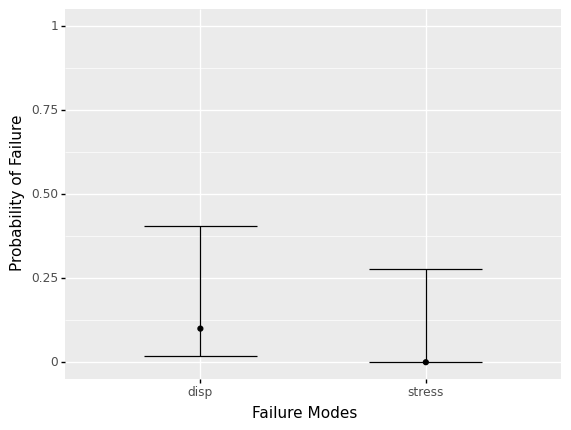

<ggplot: (8743337088368)>

In [23]:
(
    md_beam
    >> gr.ev_monte_carlo(n=10, df_det="nom")
#     >> gr.ev_monte_carlo(n=1e3, df_det="nom")
    >> gr.tf_mutate(
        fail_stress=DF.g_stress <= 0,
        fail_disp=DF.g_disp <= 0,
    )
    >> gr.tf_summarize(
        pof_stress_lo=gr.binomial_ci(DF.fail_stress, side="lo"),
        pof_stress_mu=gr.mean(DF.fail_stress),
        pof_stress_up=gr.binomial_ci(DF.fail_stress, side="up"),
        
        pof_disp_lo=gr.binomial_ci(DF.fail_disp, side="lo"),
        pof_disp_mu=gr.mean(DF.fail_disp),
        pof_disp_up=gr.binomial_ci(DF.fail_disp, side="up"),
    )
    ## Data reshaping
    >> gr.tf_gather(
        "key",
        "value",
        gr.everything(),
    )
    >> gr.tf_mutate(
        stat=gr.str_sub(DF.key, start=-2),
        mode=gr.str_sub(DF.key, start=4, end=-3),
    )
    >> gr.tf_select("value", "stat", "mode")
    >> gr.tf_spread("stat", "value")
    ## Visualize
    >> ggplot(aes("mode"))
    + geom_point(aes(y="mu"))
    + geom_errorbar(aes(ymin="lo", ymax="up"))
    + coord_cartesian(ylim=(0, 1))
    + labs(
        x="Failure Modes",
        y="Probability of Failure",
    )
)